# Laboratorio 6

- Irving Acosta 22781
- Ricardo Chuy 221007

[Repositorio](https://github.com/wwIrvingww/Lab6_DS.git)

## Avances 
### Carga de datos

### Librerias

In [1]:
from pathlib import Path
import json
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords

from pathlib import Path
import json
import pandas as pd
import re
from datetime import datetime
import numpy as np

In [2]:
# -------- helpers --------
def get_id_str(d, base="id"):
    """Devuelve d[f"{base}_str"] si existe; si no, usa d[base] -> str."""
    if not isinstance(d, dict):
        return None
    if f"{base}_str" in d and d[f"{base}_str"] is not None:
        return str(d[f"{base}_str"])
    v = d.get(base)
    if v is None:
        return None
    try:
        if isinstance(v, float) and v.is_integer():
            return str(int(v))
    except Exception:
        pass
    return str(v)

def flatten_tweet(t):
    u = t.get("user", {}) if isinstance(t.get("user"), dict) else {}

    # mentionedUsers
    musers = t.get("mentionedUsers", [])
    if not isinstance(musers, list):
        musers = []
    mentioned_ids = []
    mentioned_usernames = []
    for mu in musers:
        if isinstance(mu, dict):
            mid = get_id_str(mu, "id")
            if mid: mentioned_ids.append(mid)
            if mu.get("username"): mentioned_usernames.append(mu["username"])

    # quotedTweet
    qt = t.get("quotedTweet", {}) if isinstance(t.get("quotedTweet"), dict) else None
    qt_user = qt.get("user", {}) if qt and isinstance(qt.get("user"), dict) else {}

    # media counts
    media = t.get("media", {}) if isinstance(t.get("media"), dict) else {}
    photos_cnt = len(media.get("photos", [])) if isinstance(media.get("photos"), list) else 0
    videos_cnt = len(media.get("videos", [])) if isinstance(media.get("videos"), list) else 0
    animated_cnt = len(media.get("animated", [])) if isinstance(media.get("animated"), list) else 0

    hashtags = t.get("hashtags", []) or []
    cashtags = t.get("cashtags", []) or []

    # inReplyToUser
    iru = t.get("inReplyToUser")
    inReplyToUser_val = iru.get("username") if isinstance(iru, dict) else iru

    # descriptionLinks y pinnedIds del user
    user_descriptionLinks_cnt = len(u.get("descriptionLinks", [])) if isinstance(u.get("descriptionLinks"), list) else 0
    user_pinnedIds_val = u.get("pinnedIds")
    if isinstance(user_pinnedIds_val, list):
        # lista de IDs → siempre string limpio
        user_pinnedIds_val = ",".join(str(int(float(x))) for x in user_pinnedIds_val if x is not None)
    elif user_pinnedIds_val is not None:
        # caso raro: valor único
        try:
            user_pinnedIds_val = str(int(float(user_pinnedIds_val)))
        except Exception:
            user_pinnedIds_val = str(user_pinnedIds_val)


    return {
        "id": get_id_str(t, "id"),
        "date": t.get("date"),

        "user": u.get("username"),
        "user_id": get_id_str(u, "id"),
        "user_displayname": u.get("displayname"),
        "user_rawDescription": u.get("rawDescription"),
        "user_created": u.get("created"),
        "user_followersCount": u.get("followersCount"),
        "user_friendsCount": u.get("friendsCount"),
        "user_statusesCount": u.get("statusesCount"),
        "user_favouritesCount": u.get("favouritesCount"),
        "user_listedCount": u.get("listedCount"),
        "user_mediaCount": u.get("mediaCount"),
        "user_location": u.get("location"),
        "user_protected": u.get("protected"),
        "user_verified": u.get("verified"),
        "user_blue": u.get("blue"),
        "user_blueType": u.get("blueType"),
        "user_descriptionLinks": user_descriptionLinks_cnt,
        "user_pinnedIds": user_pinnedIds_val,

        "lang": t.get("lang"),
        "rawContent": t.get("rawContent"),
        "replyCount": t.get("replyCount"),
        "retweetCount": t.get("retweetCount"),
        "likeCount": t.get("likeCount"),
        "quoteCount": t.get("quoteCount"),
        "bookmarkedCount": t.get("bookmarkedCount"),
        "conversationId": get_id_str(t, "conversationId"),

        "hashtags": ",".join(hashtags) if hashtags else None,
        "cashtags": ",".join(cashtags) if cashtags else None,
        "mentionedUsers_ids": ",".join(mentioned_ids) if mentioned_ids else None,
        "mentionedUsers_usernames": ",".join(mentioned_usernames) if mentioned_usernames else None,

        "viewCount": t.get("viewCount"),

        "quotedTweet_id": get_id_str(qt, "id") if qt else None,
        "quotedTweet_date": qt.get("date") if qt else None,
        "quotedTweet_user_id": get_id_str(qt_user, "id") if qt_user else None,
        "quotedTweet_user_username": qt_user.get("username") if qt_user else None,

        "place": json.dumps(t.get("place"), ensure_ascii=False) if isinstance(t.get("place"), (dict, list)) else t.get("place"),
        "inReplyToTweetId": get_id_str(t, "inReplyToTweetId"),
        "inReplyToUser": inReplyToUser_val,
        "sourceLabel": t.get("sourceLabel"),

        "media_photos_count": photos_cnt,
        "media_videos_count": videos_cnt,
        "media_animated_count": animated_cnt,
    }

# -------- lectura --------
src = Path("traficogt.txt")
rows = []
bad_lines = 0
with src.open("r", encoding="utf-16") as f:
    for i, ln in enumerate(f, 1):
        ln = ln.strip()
        if not ln:
            continue
        try:
            t = json.loads(ln)
            rows.append(flatten_tweet(t))
        except json.JSONDecodeError:
            bad_lines += 1

print(f"Filas parseadas: {len(rows)} | líneas malas: {bad_lines}")

df = pd.DataFrame(rows)

# Reordenar columnas
ordered_cols = [
    "id","date","user",
    "user_id","user_displayname","user_rawDescription","user_created",
    "user_followersCount","user_friendsCount","user_statusesCount","user_favouritesCount",
    "user_listedCount","user_mediaCount","user_location","user_protected","user_verified",
    "user_blue","user_blueType","user_descriptionLinks","user_pinnedIds",
    "lang","rawContent","replyCount","retweetCount","likeCount","quoteCount",
    "bookmarkedCount","conversationId",
    "hashtags","cashtags",
    "mentionedUsers_ids","mentionedUsers_usernames",
    "viewCount",
    "quotedTweet_id","quotedTweet_date","quotedTweet_user_id","quotedTweet_user_username",
    "place","inReplyToTweetId","inReplyToUser","sourceLabel",
    "media_photos_count","media_videos_count","media_animated_count",
]
df = df.reindex(columns=[c for c in ordered_cols if c in df.columns])

print("Dimensiones:", df.shape)
display(df.head(3))

# Guardar CSV en UTF-8
df.to_csv("traficogt_flat.csv", index=False, encoding="utf-8")
print("CSV escrito en: traficogt_flat.csv")


Filas parseadas: 5604 | líneas malas: 1
Dimensiones: (5604, 44)


,id,date,user,user_id,user_displayname,user_rawDescription,user_created,user_followersCount,user_friendsCount,user_statusesCount,...,quotedTweet_date,quotedTweet_user_id,quotedTweet_user_username,place,inReplyToTweetId,inReplyToUser,sourceLabel,media_photos_count,media_videos_count,media_animated_count
0,1834236045598056867,2024-09-12 14:22:06+00:00,traficogt,93938886,traficoGT,Noticias de ciudad de Guatemala,2009-12-01 20:42:19+00:00,314368,137,52385,...,2024-09-12 00:39:56+00:00,976875408,monymmorales,None,None,None,Twitter for Android,0,0,0
1,1834029142565658846,2024-09-12 00:39:56+00:00,monymmorales,976875408,Mony,Iglesia y estado son asunto separado.\nCatólic...,2012-11-28 20:16:36+00:00,5502,4887,180436,...,None,None,None,None,None,None,Twitter for Android,0,0,0
2,1834039491826180424,2024-09-12 01:21:04+00:00,animaldgalaccia,1730828822029750272,Jairo De La Nada,Sancarlista. Estudiante de filosofía. Ideológi...,2023-12-02 05:58:56+00:00,571,158,8875,...,None,None,None,None,None,PNCdeGuatemala,Twitter for iPhone,0,0,0


CSV escrito en: traficogt_flat.csv


## Extraer mensajes

In [3]:


# --- columnas de la subtabla de mensajes (centradas en el tweet en sí) ---
message_cols = [
    # Identificación básica
    "id", "date", "conversationId", "inReplyToTweetId", "inReplyToUser",
    # Información del usuario que publicó
    "user", "user_id",
    # Contenido
    "rawContent", "lang", "hashtags", "cashtags",
    "mentionedUsers_ids", "mentionedUsers_usernames",
    "media_photos_count", "media_videos_count", "media_animated_count",
    "place", "sourceLabel",
    # Interacción
    "replyCount", "retweetCount", "likeCount", "quoteCount",
    "bookmarkedCount", "viewCount",
    # Datos de la cita (si existe)
    "quotedTweet_id", "quotedTweet_date", "quotedTweet_user_id", "quotedTweet_user_username",
]

# Quedarnos solo con las que existan en df (por robustez)
message_cols = [c for c in message_cols if c in df.columns]

# Construir subtabla
messages = df.loc[:, message_cols].copy()

# Asegurar que IDs estén en dtype string y llenar NA
id_like_cols = [
    c for c in messages.columns
    if c.lower() in ("id", "conversationid", "inreplytotweetid", "quotedtweet_id", "quotedtweet_user_id", "user_id")
    or c.lower().endswith("_id")
    or c.lower().endswith("_ids")
]

for c in id_like_cols:
    if c in messages.columns:
        messages[c] = messages[c].astype("string").fillna("NA")

# Llenar todos los valores nulos con "NA"
messages = messages.fillna("NA")

print("Subtabla mensajes -> columnas:", len(messages.columns), "| filas:", len(messages))
display(messages.head(5))

# Guardados
messages.to_csv("traficogt_messages.csv", index=False, encoding="utf-8")
print("CSV escrito en: traficogt_messages.csv")


Subtabla mensajes -> columnas: 28 | filas: 5604


,id,date,conversationId,inReplyToTweetId,inReplyToUser,user,user_id,rawContent,lang,hashtags,...,replyCount,retweetCount,likeCount,quoteCount,bookmarkedCount,viewCount,quotedTweet_id,quotedTweet_date,quotedTweet_user_id,quotedTweet_user_username
0,1834236045598056867,2024-09-12 14:22:06+00:00,1834236045598056867,NA,NA,traficogt,93938886,Es comprensible la resolución... El ruso sabe ...,es,NA,...,0,0,1,0,0,393.0,1834029142565658846,2024-09-12 00:39:56+00:00,976875408,monymmorales
1,1834029142565658846,2024-09-12 00:39:56+00:00,1834029142565658846,NA,NA,monymmorales,976875408,La corrupción de la @CC_Guatemala\nes descarad...,es,NA,...,0,56,84,4,1,1587.0,NA,NA,NA,NA
2,1834039491826180424,2024-09-12 01:21:04+00:00,1834039491826180424,NA,PNCdeGuatemala,animaldgalaccia,1730828822029750272,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,qme,NA,...,0,0,1,0,0,91.0,NA,NA,NA,NA
3,1833963729136091179,2024-09-11 20:20:01+00:00,1833963727575781534,1833963727575781534,EstacionDobleA,EstacionDobleA,1802661334355456000,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,qam,NA,...,0,0,0,0,0,46.0,NA,NA,NA,NA
4,1833665391698092330,2024-09-11 00:34:31+00:00,1833664431084949711,1833664431084949711,CubReserva,CubReserva,1155617398675988481,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,es,NA,...,0,0,1,0,0,171.0,NA,NA,NA,NA


CSV escrito en: traficogt_messages.csv


## preparacion

In [4]:


# Descargar stopwords si no las tienes
nltk.download('stopwords')
stopwords_es = set(stopwords.words('spanish'))

def clean_text(text):
    if pd.isna(text) or text == "NA":
        return "NA"
    
    # Convertir a string
    text = str(text)
    
    # Si es muy corto o vacío después de limpiar, devolver NA
    if len(text.strip()) <= 1:
        return "NA"
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Quitar URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    
    # Quitar menciones (@usuario) pero conservar el texto
    text = re.sub(r"@\w+", "", text)
    
    # Quitar hashtags (#) pero conservar el texto
    text = re.sub(r"#(\w+)", r"\1", text)
    
    # Quitar caracteres especiales excepto letras, números y espacios básicos
    text = re.sub(r"[^\w\sáéíóúñü]", " ", text)
    
    # Quitar espacios extra
    text = re.sub(r"\s+", " ", text).strip()
    
    # Tokenizar y quitar stopwords
    tokens = [t for t in text.split() if t not in stopwords_es and len(t) > 2]
    
    if not tokens:
        return "NA"
    
    return " ".join(tokens)

# Aplicar sobre la columna rawContent (o la que quieras)
df["rawContent_clean"] = df["rawContent"].apply(clean_text)

# Llenar NA explícito
df["rawContent_clean"] = df["rawContent_clean"].fillna("NA")

# Vista rápida
display(df[["rawContent", "rawContent_clean"]].head(10))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,rawContent,rawContent_clean
0,Es comprensible la resolución... El ruso sabe ...,comprensible resolución ruso sabe engrasar maq...
1,La corrupción de la @CC_Guatemala\nes descarad...,corrupción descarada falsificación documentos ...
2,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,NA
3,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,NA
4,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,urgente zona deterioro tala inmoderada tráfico...
5,@amilcarmontejo @PMTMuniGuate @Noti7Guatemala ...,avenidas calles avenida calle luz semáforo age...
6,Favor compartir \nEl vive el zona 7 Bethania ...,favor compartir vive zona bethania urgente des...
7,@traficogt @_ojoconmipisto @soy_502 @AztecaNot...,importante ponerle atención vecinos
8,@piero_coen @FJimenezmingob @traficogt @mingob...,pajas mota ahora vale
9,@erwin_fern84019 @piero_coen @FJimenezmingob @...,ayyyy arde fumen mota mejor segui chimando bebes


In [5]:
df_data = pd.read_csv("./traficogt_flat.csv")

In [6]:
print("Información inicial del dataset:")
print(f"Filas: {df_data.shape[0]}, Columnas: {df_data.shape[1]}")
print("\nPrimeras filas:")
print(df_data.head())
print("\nTipos de datos:")
print(df_data.dtypes)
print("\nValores nulos por columna:")
print(df_data.isnull().sum())

Información inicial del dataset:
Filas: 5604, Columnas: 44

Primeras filas:
                    id                       date             user  \
0  1834236045598056867  2024-09-12 14:22:06+00:00        traficogt   
1  1834029142565658846  2024-09-12 00:39:56+00:00     monymmorales   
2  1834039491826180424  2024-09-12 01:21:04+00:00  animaldgalaccia   
3  1833963729136091179  2024-09-11 20:20:01+00:00   EstacionDobleA   
4  1833665391698092330  2024-09-11 00:34:31+00:00       CubReserva   

               user_id           user_displayname  \
0             93938886                  traficoGT   
1            976875408                       Mony   
2  1730828822029750272           Jairo De La Nada   
3  1802661334355456000           Estación Doble A   
4  1155617398675988481  CUB Reserva Kanajuyu Z 16   

                                 user_rawDescription  \
0                    Noticias de ciudad de Guatemala   
1  Iglesia y estado son asunto separado.\nCatólic...   
2  Sancarlista. 

In [7]:
# selleccion de data usuarios
df_users = df_data[["user", "user_id", "user_displayname", "user_rawDescription", 
                   "user_created", "user_followersCount", "user_favouritesCount", 
                   "user_listedCount", "user_mediaCount", "user_location", 
                   "user_protected", "user_verified", "user_blue", "user_blueType", 
                   "user_descriptionLinks", "user_pinnedIds"]].copy()

# limpieza na
df_users = df_users.fillna("NA")

In [8]:
df_users['user'] = df_users['user'].astype(str).str.lower()
df_users['user_displayname'] = df_users['user_displayname'].astype(str).str.lower()

In [9]:
# limpieza de la descripcion del usuario
def clean_description(text):
    if text == "NA" or pd.isna(text):
        return "NA"
    
    # Convertir a string y minúsculas
    text = str(text).lower()
    
    # Remover URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remover menciones (@usuario)
    text = re.sub(r'@\w+', '', text)
    
    # Remover hashtags (#)
    text = re.sub(r'#\w+', '', text)
    
    # Remover caracteres especiales excepto espacios y letras básicas
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remover números si se considera necesario
    text = re.sub(r'\d+', '', text)
    
    # Remover espacios extra
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text if text != "" else "NA"

df_users['user_rawDescription'] = df_users['user_rawDescription'].apply(clean_description)

In [10]:
def clean_location(location):
    if location == "NA" or pd.isna(location):
        return "NA"
    
    location = str(location).lower()
    # Remover caracteres especiales
    location = re.sub(r'[^\w\s]', '', location)
    location = re.sub(r'\s+', ' ', location).strip()
    
    return location if location != "" else "NA"

df_users['user_location'] = df_users['user_location'].apply(clean_location)

In [11]:
# limpieza de la columna pinned ids
def clean_pinned_ids(value):
    if value == "NA" or pd.isna(value) or value == '':
        return "NA"
    try:
        # Intentar convertir a entero y luego a string
        return str(int(float(value)))
    except (ValueError, TypeError):
        return "NA"

df_users['user_pinnedIds'] = df_users['user_pinnedIds'].apply(clean_pinned_ids)

In [12]:
#limpiar descripction_links
def clean_description_links(value):
    if value == "NA" or pd.isna(value) or value == '':
        return "NA"
    try:
        # Si es una lista en formato string, convertir a lista limpia
        if isinstance(value, str) and value.startswith('[') and value.endswith(']'):
            links = eval(value)
            if isinstance(links, list):
                return ', '.join([str(link).lower() for link in links])
        return str(value).lower()
    except:
        return "NA"

df_users['user_descriptionLinks'] = df_users['user_descriptionLinks'].apply(clean_description_links)

In [13]:

bool_columns = ['user_protected', 'user_verified', 'user_blue']
for col in bool_columns:
    df_users[col] = df_users[col].apply(lambda x: True if str(x).lower() in ['true', '1', 'yes'] else False)


df_users['user_created'] = pd.to_datetime(df_users['user_created'], errors='coerce')
# Para los valores que no se pudieron convertir, usar una fecha por defecto o "NA"
df_users['user_created'] = df_users['user_created'].fillna(pd.Timestamp('2000-01-01'))

numeric_columns = ['user_followersCount', 'user_favouritesCount', 'user_listedCount', 'user_mediaCount']
for col in numeric_columns:
    df_users[col] = pd.to_numeric(df_users[col], errors='coerce').fillna(0).astype(int)

In [14]:
# Eliminar duplicados basados en user_id
print(f"Filas antes de eliminar duplicados: {len(df_users)}")
df_users = df_users.drop_duplicates(subset=['user_id'])
print(f"Filas después de eliminar duplicados: {len(df_users)}")

Filas antes de eliminar duplicados: 5604
Filas después de eliminar duplicados: 2071


In [15]:
df_users.head(10)

,user,user_id,user_displayname,user_rawDescription,user_created,user_followersCount,user_favouritesCount,user_listedCount,user_mediaCount,user_location,user_protected,user_verified,user_blue,user_blueType,user_descriptionLinks,user_pinnedIds
0,traficogt,93938886,traficogt,noticias de ciudad de guatemala,2009-12-01 20:42:19+00:00,314368,3471,291,1292,guatemala,False,False,False,NA,0,NA
1,monymmorales,976875408,mony,iglesia y estado son asunto separado católica ...,2012-11-28 20:16:36+00:00,5502,274770,24,16644,guatemala frijolandia,False,False,False,NA,0,1794803010935431424
2,animaldgalaccia,1730828822029750272,jairo de la nada,sancarlista estudiante de filosofía ideológica...,2023-12-02 05:58:56+00:00,571,25257,2,1013,macondo,False,False,False,NA,1,1830424083143512576
3,estaciondoblea,1802661334355456000,estación doble a,si no ayuda no estorbe y no chingue,2024-06-17 11:16:06+00:00,18,30,0,11,NA,False,False,False,NA,0,NA
4,cubreserva,1155617398675988481,cub reserva kanajuyu z 16,preocupados por el medio ambiente somos una re...,2019-07-28 23:13:52+00:00,170,326,0,75,NA,False,False,False,NA,0,NA
5,alejandro2024gt,730220333576282112,alejandro alvarez,NA,2016-05-11 02:17:49+00:00,2,4,0,101,NA,False,False,False,NA,0,NA
6,julyponce21,3012525020,negrocorazón,NA,2015-02-07 15:53:17+00:00,208,32741,0,353,NA,False,False,False,NA,0,1414027750357229568
8,alexdel92022343,1311834124450172928,lanaranjamecanica,nativo de san goloteo el chiquito experto en i...,2020-10-02 01:03:54+00:00,656,7604,1,3647,guatemala,False,False,False,NA,0,1580392961195462656
9,bullgarrafuerte,1747398811792687104,josé aldana,NA,2024-01-16 23:22:01+00:00,1,246,0,1,guatemala,False,False,False,NA,0,NA
10,dbeatrizmb,3303444667,dora beatriz molina,NA,2015-08-01 14:01:39+00:00,1320,571540,8,41,NA,False,False,False,NA,0,NA


In [16]:
print("\nValores nulos por columna:")
print(df_users.isnull().sum())


Valores nulos por columna:
user                     0
user_id                  0
user_displayname         0
user_rawDescription      0
user_created             0
user_followersCount      0
user_favouritesCount     0
user_listedCount         0
user_mediaCount          0
user_location            0
user_protected           0
user_verified            0
user_blue                0
user_blueType            0
user_descriptionLinks    0
user_pinnedIds           0
dtype: int64


In [17]:
df_users.to_csv("usuarios.csv", index= False)

In [18]:
#trayendo el csv de mensajes
messages = pd.read_csv('traficogt_messages.csv')

In [19]:
# acá se hace la parte de creación de relaciones entre los nodos/usuarios usando las interacciones entre usuarios como conexiones:
# Crear DataFrame de interacciones para el grafo
# Función mejorada para extraer interacciones con filtrado de valores inválidos
def extract_interactions(row):
    interactions = []
    user = str(row.get('user', 'NA')).lower()
    user_id = str(row.get('user_id', 'NA'))
    tweet_id = str(row.get('id', 'NA'))
    
    # Validar que el usuario fuente sea válido
    if user == 'nan' or user == 'na' or not user or user.strip() == '':
        return interactions
    
    # 1. Menciones en el contenido
    if row.get('mentionedUsers_usernames', 'NA') != 'NA':
        mentions_str = str(row['mentionedUsers_usernames'])
        if mentions_str not in ['nan', 'NA', '']:
            mentions = mentions_str.split(',')
            for mention in mentions:
                mention = mention.strip().lower()
                # Filtrar menciones inválidas
                if (mention and mention != 'nan' and mention != 'na' and 
                    mention != user and not mention.startswith('nan')):
                    interactions.append({
                        'source_user': user,
                        'source_user_id': user_id,
                        'target_user': mention,
                        'interaction_type': 'mention',
                        'tweet_id': tweet_id
                    })
    
    # 2. Respuestas
    if row.get('inReplyToUser', 'NA') != 'NA':
        reply_to = str(row['inReplyToUser']).lower()
        # Filtrar respuestas inválidas
        if (reply_to and reply_to != 'nan' and reply_to != 'na' and 
            reply_to != user and not reply_to.startswith('nan')):
            interactions.append({
                'source_user': user,
                'source_user_id': user_id,
                'target_user': reply_to,
                'interaction_type': 'reply',
                'tweet_id': tweet_id
            })
    
    # 3. Citas (quotes)
    if row.get('quotedTweet_user_username', 'NA') != 'NA':
        quoted_user = str(row['quotedTweet_user_username']).lower()
        # Filtrar citas inválidas
        if (quoted_user and quoted_user != 'nan' and quoted_user != 'na' and 
            quoted_user != user and not quoted_user.startswith('nan')):
            interactions.append({
                'source_user': user,
                'source_user_id': user_id,
                'target_user': quoted_user,
                'interaction_type': 'quote',
                'tweet_id': tweet_id
            })
    
    return interactions

# Extraer todas las interacciones
all_interactions = []
for _, row in messages.iterrows():
    interactions = extract_interactions(row)
    all_interactions.extend(interactions)

# Crear DataFrame de interacciones
df_interactions = pd.DataFrame(all_interactions)

# Filtrar filas adicionales que puedan tener valores inválidos
df_interactions = df_interactions[
    (df_interactions['source_user'] != 'nan') &
    (df_interactions['source_user'] != 'na') &
    (df_interactions['target_user'] != 'nan') &
    (df_interactions['target_user'] != 'na') &
    (~df_interactions['source_user'].isna()) &
    (~df_interactions['target_user'].isna()) &
    (df_interactions['source_user'].str.strip() != '') &
    (df_interactions['target_user'].str.strip() != '')
]

# Eliminar duplicados
df_interactions = df_interactions.drop_duplicates()

print(f"Total de interacciones válidas: {len(df_interactions)}")
print(f"Usuarios fuente únicos: {df_interactions['source_user'].nunique()}")
print(f"Usuarios destino únicos: {df_interactions['target_user'].nunique()}")

# Mostrar sample de interacciones limpias
print("\nSample de interacciones válidas:")
print(df_interactions.head(10))

# Guardar CSV de interacciones limpias
df_interactions.to_csv('traficogt_interactions_clean.csv', index=False)
print("CSV de interacciones limpias guardado: traficogt_interactions_clean.csv")

Total de interacciones válidas: 15523
Usuarios fuente únicos: 1973
Usuarios destino únicos: 1117

Sample de interacciones válidas:
       source_user       source_user_id     target_user interaction_type  \
0        traficogt             93938886    monymmorales            quote   
1     monymmorales            976875408    cc_guatemala          mention   
2  animaldgalaccia  1730828822029750272  pncdeguatemala          mention   
3  animaldgalaccia  1730828822029750272     mingobguate          mention   
4  animaldgalaccia  1730828822029750272  fjimenezmingob          mention   
5  animaldgalaccia  1730828822029750272    diegoedeleon          mention   
6  animaldgalaccia  1730828822029750272  amilcarmontejo          mention   
7  animaldgalaccia  1730828822029750272       traficogt          mention   
8  animaldgalaccia  1730828822029750272  pncdeguatemala            reply   
9   estaciondoblea  1802661334355456000  amilcarmontejo          mention   

              tweet_id  
0  1834

# Análisis exploratorio

Ahora mismo tenemos 3 archivos principales:

* traficogt_messages.csv
* trafico_interactions_clean.csv
* usuarios.csv

El primer archivo es el que contiene todos los mensajes e información esencial del usuario para poder encontrar relaciones. Datos comoo el nombre del usuario y su id, además de toda la data del mensaje obviamente. Luego tenemos el de trafico_interactions_clean, este archivo contiene todas las relaciones entre usuarios, que son representados con interacciones. Algunas de las interacciones pueden ser respuestas, retweet, mención etc. Luego está el csv de usuarios, que contiene exclusivamente la información de los usuarios con el cuidado de no tener usuarios repetidos.

## Análisis de los mensajes

=== INFORMACIÓN BÁSICA: MENSAJES ===
Dimensiones: 5604 filas, 28 columnas

Valores nulos por columna:
id                              0
date                            0
conversationId                  0
inReplyToTweetId             1613
inReplyToUser                1454
user                            0
user_id                         0
rawContent                      0
lang                            0
hashtags                     5200
cashtags                     5604
mentionedUsers_ids           1117
mentionedUsers_usernames     1117
media_photos_count              0
media_videos_count              0
media_animated_count            0
place                        5564
sourceLabel                     0
replyCount                      0
retweetCount                    0
likeCount                       0
quoteCount                      0
bookmarkedCount                 0
viewCount                       4
quotedTweet_id               4993
quotedTweet_date             4993
quotedTweet_us

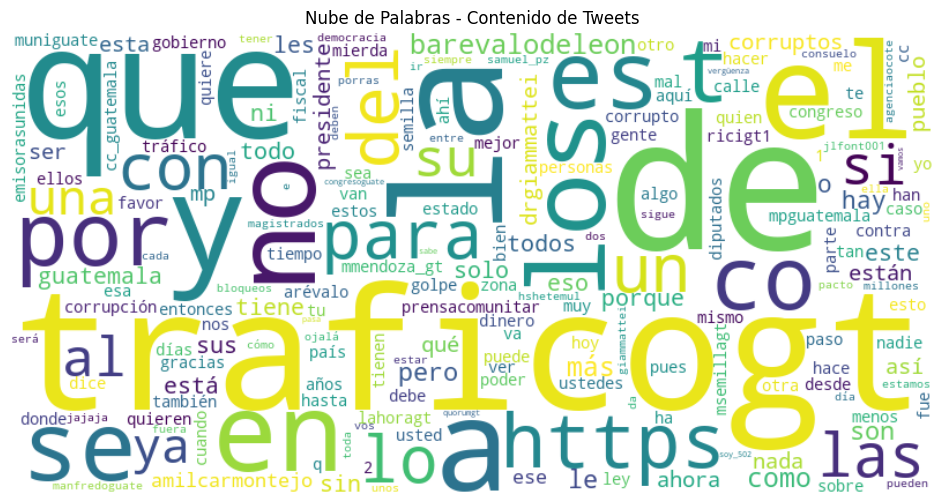

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Cargar los datos
messages = pd.read_csv('traficogt_messages.csv')
df_users = pd.read_csv('usuarios.csv')  # Asumiendo que se guardó con este nombre
df_interactions = pd.read_csv('traficogt_interactions_clean.csv')

# Función para valores únicos y nulos
def basic_info(df, name):
    print(f"=== INFORMACIÓN BÁSICA: {name} ===")
    print(f"Dimensiones: {df.shape[0]} filas, {df.shape[1]} columnas")
    print(f"\nValores nulos por columna:")
    print(df.isnull().sum())
    print(f"\nTipos de datos:")
    print(df.dtypes)
    print("\n" + "="*50)

# Función para análisis de texto
def analyze_text_column(df, column_name, title):
    print(f"\n=== ANÁLISIS DE TEXTO: {title} ===")
    
    # Longitud promedio del texto
    df['text_length'] = df[column_name].astype(str).apply(len)
    print(f"Longitud promedio del texto: {df['text_length'].mean():.2f} caracteres")
    
    # Conteo de palabras
    df['word_count'] = df[column_name].astype(str).apply(lambda x: len(x.split()))
    print(f"Promedio de palabras: {df['word_count'].mean():.2f}")
    
    # Palabras más comunes
    all_text = ' '.join(df[column_name].astype(str).dropna())
    words = re.findall(r'\b\w+\b', all_text.lower())
    word_freq = Counter(words)
    print(f"Palabras más comunes: {word_freq.most_common(10)}")
    
    return word_freq

# 1. ANÁLISIS DE MENSAJES (TWEETS)
basic_info(messages, "MENSAJES")

print("\n=== ESTADÍSTICAS DE MENSAJES ===")
print(f"Total de tweets: {len(messages)}")
print(f"Rango de fechas: {messages['date'].min()} to {messages['date'].max()}")
print(f"Idiomas principales: {messages['lang'].value_counts().head(5).to_dict()}")

# Análisis de interacciones en tweets
print(f"\n=== INTERACCIONES EN TWEETS ===")
print(f"Promedio de likes: {messages['likeCount'].mean():.2f}")
print(f"Promedio de retweets: {messages['retweetCount'].mean():.2f}")
print(f"Promedio de respuestas: {messages['replyCount'].mean():.2f}")
print(f"Promedio de vistas: {messages['viewCount'].mean():.2f}")

# Tweets más populares
top_tweets = messages.nlargest(5, 'likeCount')[['id', 'rawContent', 'likeCount', 'retweetCount']]
print("\nTweets más populares (por likes):")
for i, row in top_tweets.iterrows():
    print(f"  {row['likeCount']} likes: {row['rawContent'][:100]}...")

# Análisis de hashtags
hashtags_all = ' '.join(messages['hashtags'].dropna().astype(str))
hashtag_freq = Counter(re.findall(r'\b\w+\b', hashtags_all.lower()))
print(f"\nHashtags más comunes: {hashtag_freq.most_common(10)}")

# Nube de palabras del contenido
word_freq_messages = analyze_text_column(messages, 'rawContent', 'Contenido de Tweets')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_messages)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Contenido de Tweets')
plt.show()

## Análisis de los usuarios

=== INFORMACIÓN BÁSICA: USUARIOS ===
Dimensiones: 2071 filas, 16 columnas

Valores nulos por columna:
user                        0
user_id                     0
user_displayname            0
user_rawDescription       917
user_created                0
user_followersCount         0
user_favouritesCount        0
user_listedCount            0
user_mediaCount             0
user_location            1040
user_protected              0
user_verified               0
user_blue                   0
user_blueType            2059
user_descriptionLinks       0
user_pinnedIds           1648
dtype: int64

Tipos de datos:
user                      object
user_id                    int64
user_displayname          object
user_rawDescription       object
user_created              object
user_followersCount        int64
user_favouritesCount       int64
user_listedCount           int64
user_mediaCount            int64
user_location             object
user_protected              bool
user_verified            

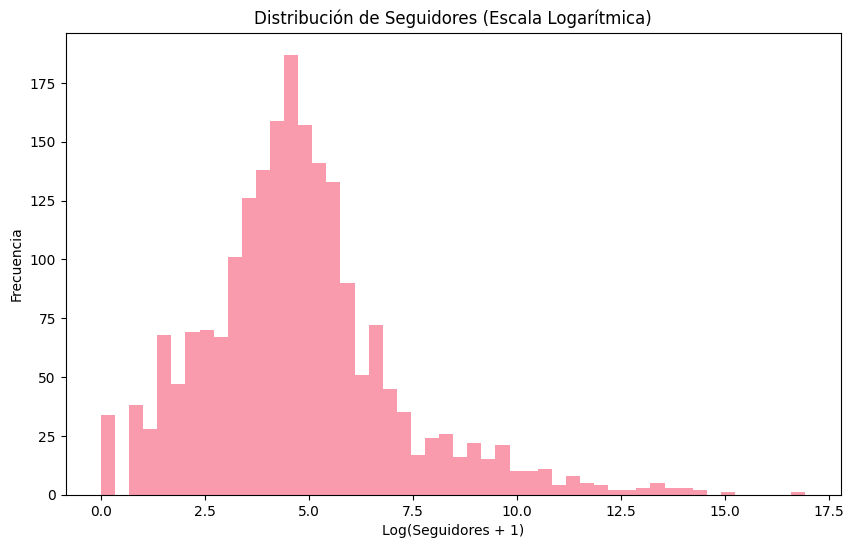

In [21]:
basic_info(df_users, "USUARIOS")

print("\n=== ESTADÍSTICAS DE USUARIOS ===")
print(f"Usuarios únicos: {len(df_users)}")
print(f"Usuarios verificados: {df_users['user_verified'].sum()}")

# Estadísticas de seguidores
print(f"\n=== ESTADÍSTICAS DE SEGUIDORES ===")
print(f"Máximo seguidores: {df_users['user_followersCount'].max()}")
print(f"Mínimo seguidores: {df_users['user_followersCount'].min()}")
print(f"Promedio seguidores: {df_users['user_followersCount'].mean():.2f}")
print(f"Mediana seguidores: {df_users['user_followersCount'].median()}")

# Top usuarios por seguidores
top_users = df_users.nlargest(10, 'user_followersCount')[['user', 'user_displayname', 'user_followersCount']]
print("\nTop 10 usuarios por seguidores:")
print(top_users.to_string(index=False))

# Distribución de seguidores (log scale para mejor visualización)
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(df_users['user_followersCount']), bins=50, alpha=0.7)
plt.xlabel('Log(Seguidores + 1)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Seguidores (Escala Logarítmica)')
plt.show()

## Análisis de las relaciones

=== INFORMACIÓN BÁSICA: INTERACCIONES ===
Dimensiones: 15523 filas, 5 columnas

Valores nulos por columna:
source_user         0
source_user_id      0
target_user         0
interaction_type    0
tweet_id            0
dtype: int64

Tipos de datos:
source_user         object
source_user_id       int64
target_user         object
interaction_type    object
tweet_id             int64
dtype: object


=== ESTADÍSTICAS DE INTERACCIONES ===
Total de interacciones: 15523
Tipos de interacción: {'mention': 10854, 'reply': 4076, 'quote': 593}

Top 10 usuarios más activos:
source_user
traficogt          698
batallonjalapa     455
mildred_gaitan     384
angeln8            197
chofito63569841    166
alejandro2024gt    165
cubreserva         151
iovittor           139
hellboy17oc        129
papaabumario       105
Name: count, dtype: int64

Top 10 usuarios más mencionados:
target_user
traficogt          5622
barevalodeleon      474
prensacomunitar     322
lahoragt            309
amilcarmontejo      224


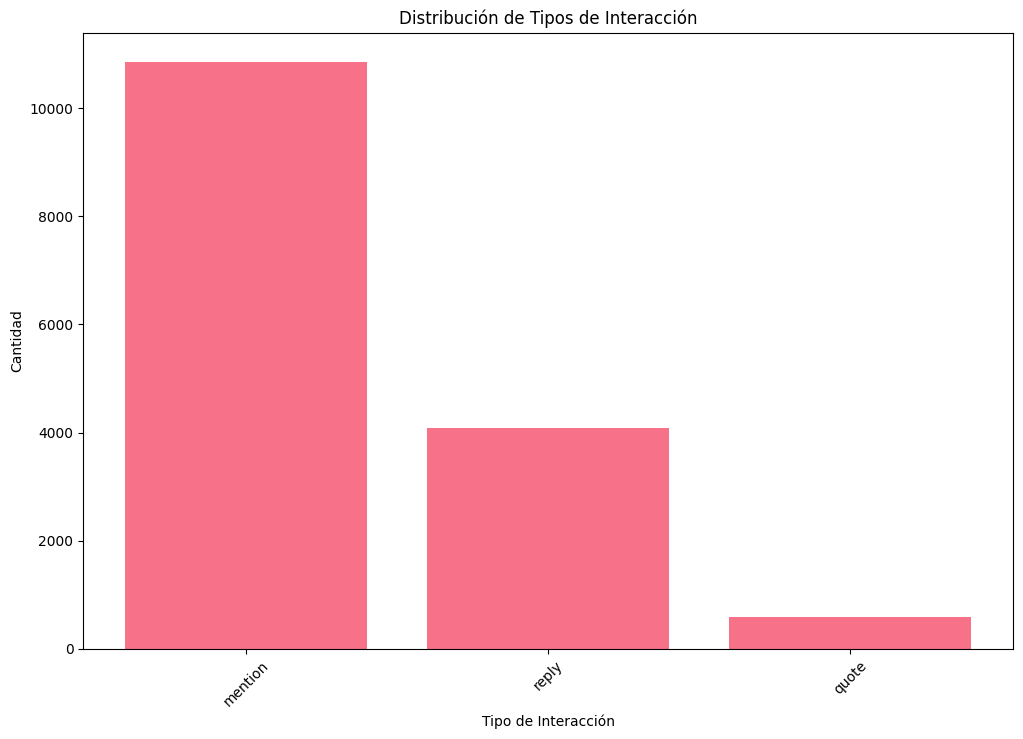

In [36]:
basic_info(df_interactions, "INTERACCIONES")

print("\n=== ESTADÍSTICAS DE INTERACCIONES ===")
print(f"Total de interacciones: {len(df_interactions)}")
print(f"Tipos de interacción: {df_interactions['interaction_type'].value_counts().to_dict()}")

# Usuarios más activos
top_sources = df_interactions['source_user'].value_counts().head(10)
print(f"\nTop 10 usuarios más activos:")
print(top_sources)

# Usuarios más mencionados
top_targets = df_interactions['target_user'].value_counts().head(10)
print(f"\nTop 10 usuarios más mencionados:")
print(top_targets)

# Matriz de interacciones por tipo
interaction_matrix = pd.crosstab(df_interactions['source_user'], df_interactions['interaction_type'])
print(f"\nInteracciones por tipo:")
print(interaction_matrix.sum())

# Grafo de interacciones
plt.figure(figsize=(12, 8))
interaction_counts = df_interactions['interaction_type'].value_counts()
plt.bar(interaction_counts.index, interaction_counts.values)
plt.title('Distribución de Tipos de Interacción')
plt.xlabel('Tipo de Interacción')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

Habiendo obtenido información sobre los sets de datos que tenemo, vemos que hay información interesante tanto en los mensajes, usuarios y también en las relaciones. Pero además de distribuciones y conteos también es posible analizar más información dentre de los datos. Este análisis inicial nos da una idea general de los datos y sus distribuciones, pero al ver los datos nos hemos preugntado lo siguiente:

* ¿Cuáles son las horas pico de actividad en Twitter para hablar sobre el tráfico?
* ¿Cuales son los hashtags más populares?
* ¿Cuales son los usuarios con mas seguidores?
* ¿Cuantos usuarios están verificados vs cuantos están con blue (check azul)?




1. ¿Cuáles son las horas pico de actividad en Twitter?


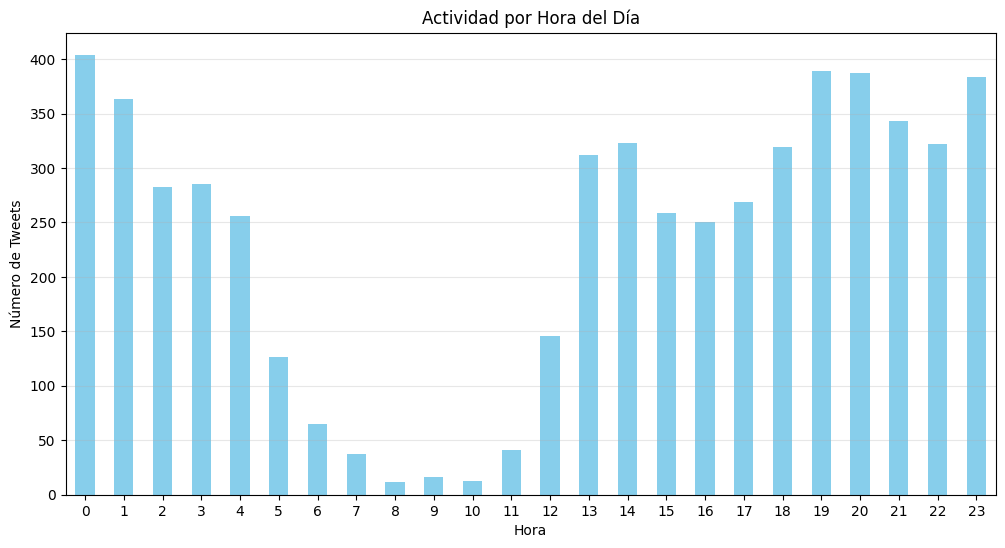

Horas con mayor actividad: {0: np.int64(404), 19: np.int64(389), 20: np.int64(387)}


In [37]:
# 4. PREGUNTAS INTERESANTES Y RESPUESTAS

# Pregunta 1: ¿Cuáles son las horas pico de actividad en Twitter?
print("\n1. ¿Cuáles son las horas pico de actividad en Twitter?")
messages['datetime'] = pd.to_datetime(messages['date'])
messages['hour'] = messages['datetime'].dt.hour
hourly_activity = messages['hour'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
hourly_activity.plot(kind='bar', color='skyblue')
plt.title('Actividad por Hora del Día')
plt.xlabel('Hora')
plt.ylabel('Número de Tweets')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"Horas con mayor actividad: {dict(hourly_activity.nlargest(3))}")



Curiosamente dentro de los tweets se ve que la mayor parte del tiempo hay grandes cantidades de tweets a lo largo del día excepto de las 5am a las 12. Esto llama la atención ya que incluso en horas de la madrugada como de las 0 a las 4 horas hay bastantes más interacciones. De igual manera de en la tarde y altas horas de la noche es que hay varios tweets. Seguramente esto se deba a que la mayoría de personas entre las 5 y 12 se encontarán o bien en el trabajo o estudiando. Esta métrica es interesante ya que podría apoyar a personas a elegir en que momentos realmente es el más oportuno para poder hacer una publicación para que alcance a lamyor cantidad de presonas. parece haerb más actividad especialmente en 18, 19, 23 y 0 horas.


2. ¿Cuáles son los hashtags más populares?
Top 15 hashtags más populares:
  #ahora: 30 menciones
  #guatemala: 25 menciones
  #ahoralh: 19 menciones
  #urgente: 16 menciones
  #traficogt: 16 menciones
  #renunciengolpistas: 15 menciones
  #paronacionalindefinido: 9 menciones
  #lahoradeactualizarnos: 8 menciones
  #guateresiste: 8 menciones
  #paronacionaindefinido: 8 menciones
  #lhnacionales: 7 menciones
  #lhenbreve: 7 menciones
  #adiosconsuelo: 7 menciones
  #tráfico: 7 menciones
  #consueloporras: 6 menciones


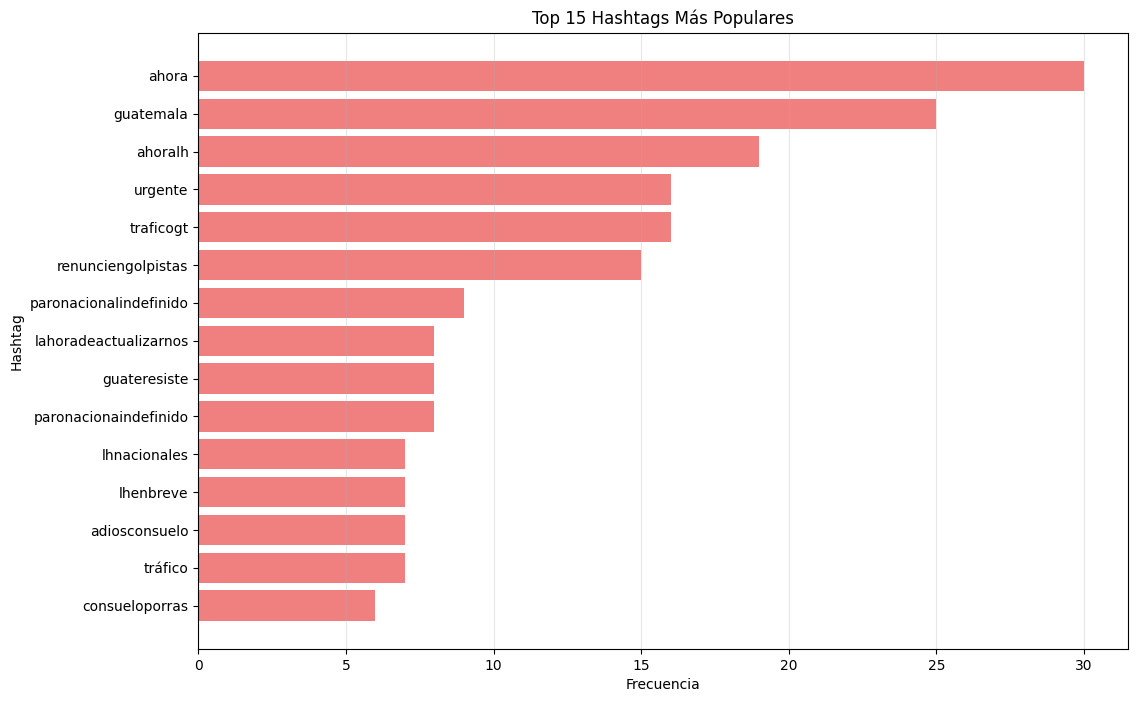


Análisis de engagement por hashtag:

Top 10 hashtags por engagement promedio:
  #nuevocongreso: 16086.00 engagement promedio
  #bloqueossemilla: 7227.00 engagement promedio
  #paronacionaiindefinido: 6772.00 engagement promedio
  #cambiodemando: 4557.00 engagement promedio
  #euprocesodetransición: 3524.00 engagement promedio
  #videolh: 3330.00 engagement promedio
  #estadodederecho: 2958.00 engagement promedio
  #guatedecide: 2693.00 engagement promedio
  #capital: 2693.00 engagement promedio
  #altaverapaz: 2693.00 engagement promedio


In [38]:
# Pregunta 2: ¿Cuáles son los hashtags más populares?
print("\n2. ¿Cuáles son los hashtags más populares?")

# Extraer y analizar hashtags
def extract_hashtags(text):
    if pd.isna(text) or text == 'NA':
        return []
    return re.findall(r'#(\w+)', str(text).lower())

# Extraer todos los hashtags
all_hashtags = []
for hashtags_str in messages['hashtags']:
    if pd.notna(hashtags_str) and hashtags_str != 'NA':
        hashtags_list = str(hashtags_str).split(',')
        all_hashtags.extend([tag.strip().lower() for tag in hashtags_list if tag.strip()])

hashtag_freq = Counter(all_hashtags)
top_hashtags = hashtag_freq.most_common(15)

print("Top 15 hashtags más populares:")
for hashtag, count in top_hashtags:
    print(f"  #{hashtag}: {count} menciones")

# Visualización de hashtags
plt.figure(figsize=(12, 8))
hashtags_df = pd.DataFrame(top_hashtags, columns=['Hashtag', 'Frecuencia'])
plt.barh(hashtags_df['Hashtag'], hashtags_df['Frecuencia'], color='lightcoral')
plt.xlabel('Frecuencia')
plt.ylabel('Hashtag')
plt.title('Top 15 Hashtags Más Populares')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.show()

# Análisis de engagement por hashtag
print("\nAnálisis de engagement por hashtag:")
hashtag_engagement = {}
for index, row in messages.iterrows():
    if pd.notna(row['hashtags']) and row['hashtags'] != 'NA':
        engagement = row['likeCount'] + row['retweetCount'] + row['replyCount']
        hashtags = str(row['hashtags']).split(',')
        for tag in hashtags:
            tag = tag.strip().lower()
            if tag:
                if tag not in hashtag_engagement:
                    hashtag_engagement[tag] = []
                hashtag_engagement[tag].append(engagement)

# Calcular engagement promedio por hashtag
avg_engagement = {tag: np.mean(engagements) for tag, engagements in hashtag_engagement.items()}
top_engagement_hashtags = sorted(avg_engagement.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 hashtags por engagement promedio:")
for hashtag, avg_eng in top_engagement_hashtags:
    print(f"  #{hashtag}: {avg_eng:.2f} engagement promedio")

Si evaluamos específcicamente por la cantidad de uso del hashtag se puede ver que realmente hay bastante variedad en los temas. El hashtag más común en este sentido es #ahora. Seguramente sea porque todos los tweets están relacionados de una forma u otra con el tráfico y eventos recientes. De lo que sabemos, ese hashtag se usa para noticias recientes y para que las personas tengan un hashtag para ver lo último que está pasando. Luego le siguen hastags relacionados al país y de igual manera relacionados a noticias: #Guatemala, horalh, traficogt, etc. Lo interesante es que también hay distintos hashtags que hacen referencia a renuncias y el apro nacional. Esto tiene sentido si recordamos eventos recientes donde hubieron manifestaciones, paros, y demás situaciones que empeorarón el tráfico e incluso detuvieron actividades en el país. Los conteos pueden verse bajos

Ahora si analizamos el engagement promedio vemos que los hastags cambian un poco, siguen habiendo relacionados bloqueos y el paro nacional, junto con otros temas relacionados pero realmente es más sobre temas políticos en este caso. Viendo esto podemos comenzar a hacer la asociación que el tráfico puede que se vea afectado en gran manera con eventos políticos y huelgas por culpa de la inconformiadad del puelbo guatemalteco.


3. ¿Cuáles son los usuarios con más seguidores dentro del set de datos?
Top 15 usuarios por número de seguidores:
  1477. cnnee (cnn en español) 
      Seguidores: 22,578,187
  1267. patriciajaniot (patricia janiot) 
      Seguidores: 2,990,852
  45. prensa_libre (prensa libre) 
      Seguidores: 1,685,961
  460. emisorasunidas (emisoras unidas) 
      Seguidores: 1,583,157
  463. dw_espanol (dw español) 
      Seguidores: 1,441,832
  515. soy_502 (soy 502) 
      Seguidores: 1,258,178
  943. guatevision_tv (guatevisión) 
      Seguidores: 1,222,148
  1384. el_periodico (elperiódico) 
      Seguidores: 955,543
  1109. pikaso_me (pikaso) 
      Seguidores: 887,804
  1050. amilcarmontejo (amilcar montejo) 
      Seguidores: 856,742
  1418. threadreaderapp (thread reader app) 
      Seguidores: 763,397
  1908. muniguate (muniguate) 
      Seguidores: 748,587
  689. canalantigua (canal antigua) 
      Seguidores: 593,900
  599. renasuspendido (el renacido) 
      Seguidores: 560,586
  37.

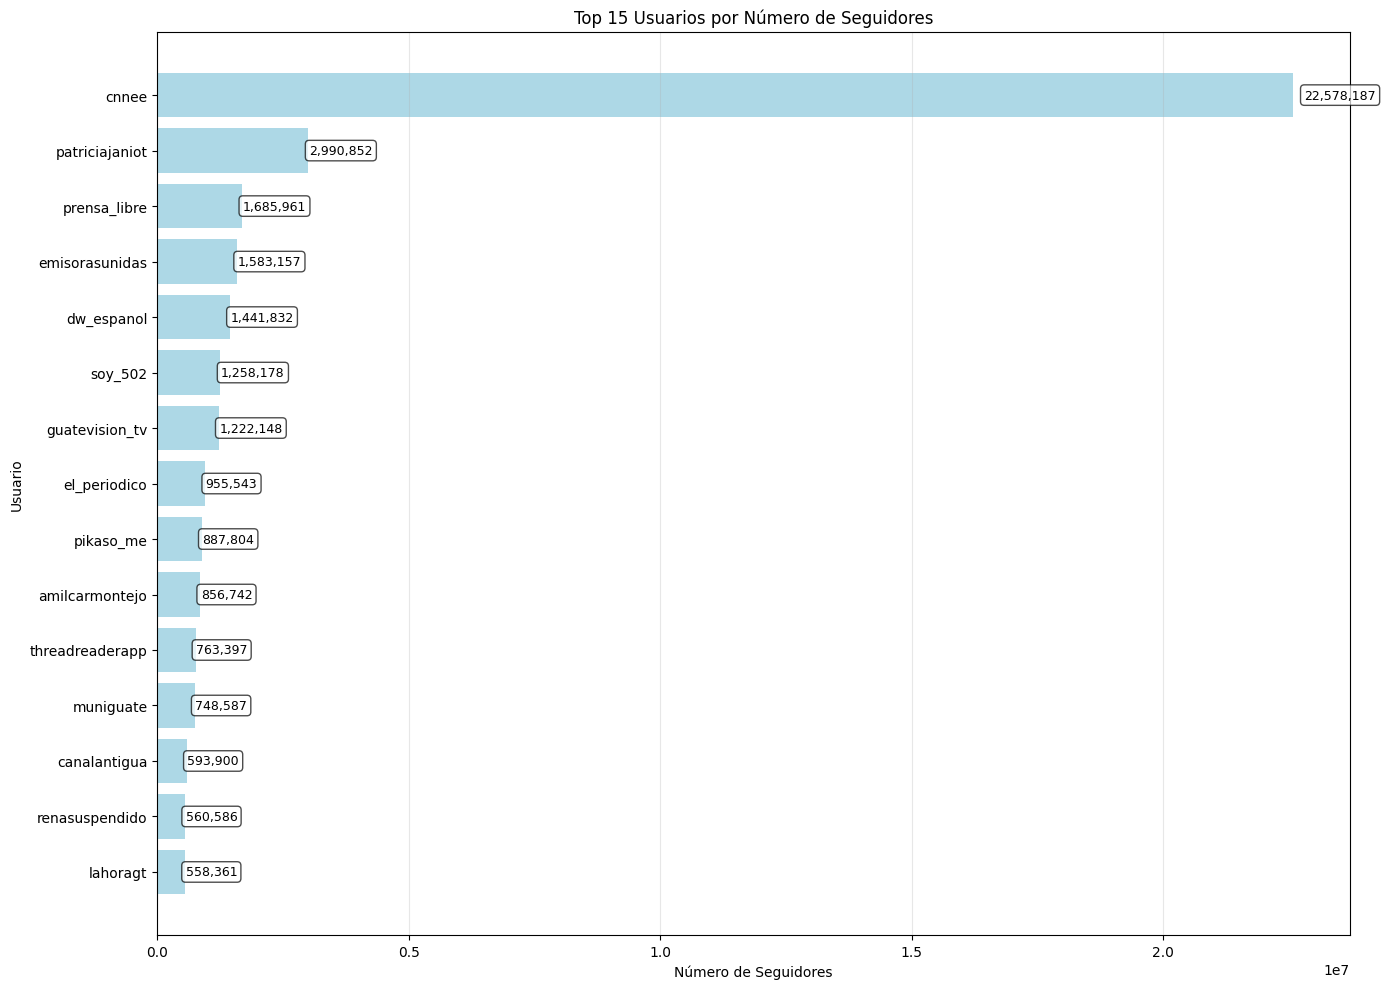

In [39]:
# Pregunta 3: ¿Cuáles son los usuarios con más seguidores dentro del set de datos?
print("\n3. ¿Cuáles son los usuarios con más seguidores dentro del set de datos?")

# Top 15 usuarios por seguidores
top_followers = df_users.nlargest(15, 'user_followersCount')[['user', 'user_displayname', 'user_followersCount', 'user_verified']]
print("Top 15 usuarios por número de seguidores:")
for i, row in top_followers.iterrows():
    verification = "✓" if row['user_verified'] else ""
    print(f"  {i+1:2d}. {row['user']} ({row['user_displayname']}) {verification}")
    print(f"      Seguidores: {row['user_followersCount']:,}")

# Visualización de top usuarios por seguidores
plt.figure(figsize=(14, 10))
plt.barh(top_followers['user'], top_followers['user_followersCount'], 
         color=['gold' if verified else 'lightblue' for verified in top_followers['user_verified']])
plt.xlabel('Número de Seguidores')
plt.ylabel('Usuario')
plt.title('Top 15 Usuarios por Número de Seguidores')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Agregar valores en las barras
for i, (value, verified) in enumerate(zip(top_followers['user_followersCount'], top_followers['user_verified'])):
    plt.text(value + value * 0.01, i, f'{value:,}', va='center', fontsize=9,
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.show()

En esta gráfica realmente no encontramos algún insight tan relevante con respecto al tráfico, todos los usuarios con más eguidores son empresas o noticieros relacionados al periodismo y noticias. tal vez el más destacado sería patriciajianot. Investigando encontramos que es una periodista colombiana, pero que eventtualmente ahce comentarios sobre eventos políticos y noticias importantes dentro del país. En el caso de cnnee, es la cuenta de CNN en español.


4. ¿Cuántas personas están verificadas y cuántas tienen cuenta azul?

Estadísticas de verificación:
  Usuarios verificados: 0
  Usuarios no verificados: 2071
  Porcentaje de verificados: 0.00%

Estadísticas de cuenta azul:
  Usuarios con cuenta azul: 92
  Usuarios sin cuenta azul: 1979
  Porcentaje con cuenta azul: 4.44%

Usuarios con verificación Y cuenta azul: 0
Porcentaje con ambas: 0.00%


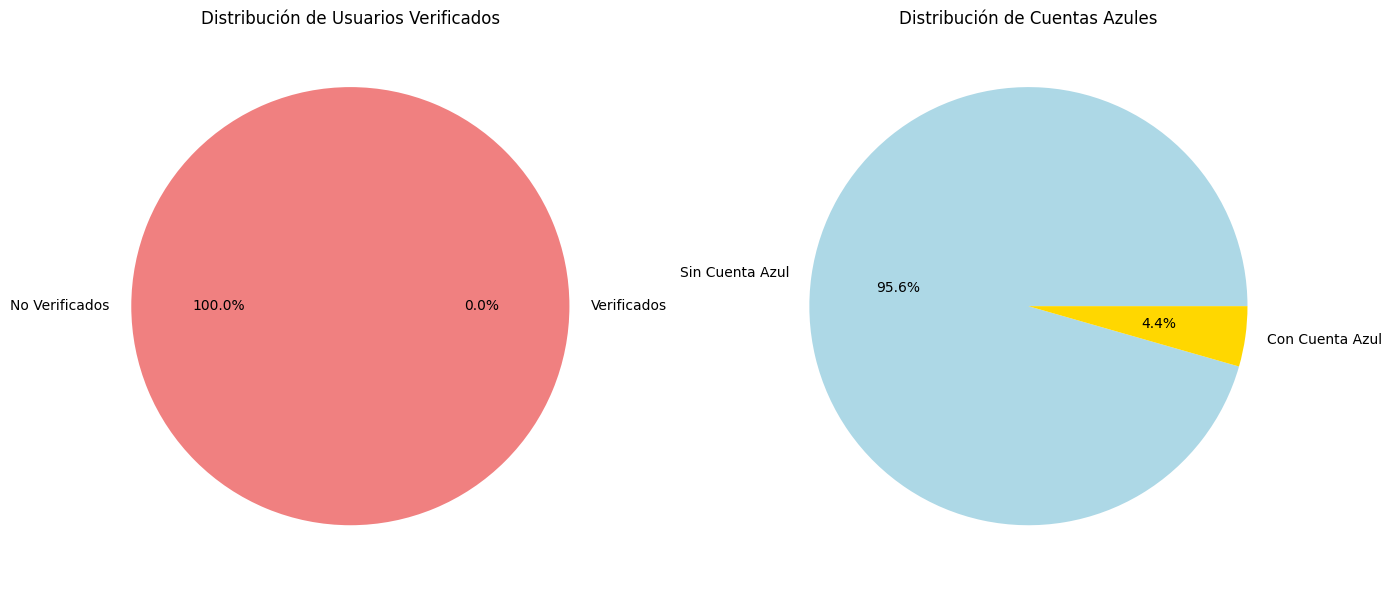


Análisis de seguidores por tipo de cuenta:
  Promedio seguidores - Verificados: nan
  Promedio seguidores - No verificados: 22052.98
  Promedio seguidores - Cuenta azul: 432099.52
  Promedio seguidores - Sin cuenta azul: 2990.69


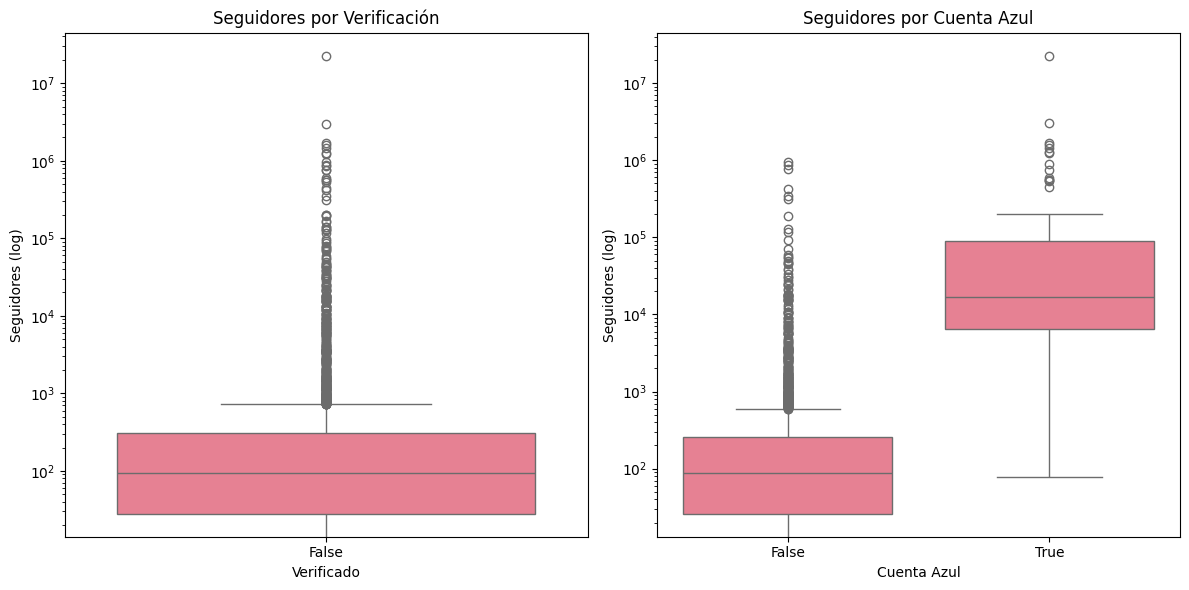

In [40]:
# Pregunta 4: ¿Cuántas personas están verificadas y cuántas tienen cuenta azul?
print("\n4. ¿Cuántas personas están verificadas y cuántas tienen cuenta azul?")

# Estadísticas de verificación
verified_stats = df_users['user_verified'].value_counts()
blue_stats = df_users['user_blue'].value_counts()

print(f"\nEstadísticas de verificación:")
print(f"  Usuarios verificados: {verified_stats.get(True, 0)}")
print(f"  Usuarios no verificados: {verified_stats.get(False, 0)}")
print(f"  Porcentaje de verificados: {verified_stats.get(True, 0)/len(df_users)*100:.2f}%")

print(f"\nEstadísticas de cuenta azul:")
print(f"  Usuarios con cuenta azul: {blue_stats.get(True, 0)}")
print(f"  Usuarios sin cuenta azul: {blue_stats.get(False, 0)}")
print(f"  Porcentaje con cuenta azul: {blue_stats.get(True, 0)/len(df_users)*100:.2f}%")

# Usuarios que tienen ambas características
both_verified_and_blue = len(df_users[(df_users['user_verified'] == True) & (df_users['user_blue'] == True)])
print(f"\nUsuarios con verificación Y cuenta azul: {both_verified_and_blue}")
print(f"Porcentaje con ambas: {both_verified_and_blue/len(df_users)*100:.2f}%")

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de verificación
verified_labels = ['No Verificados', 'Verificados']
verified_values = [verified_stats.get(False, 0), verified_stats.get(True, 0)]
ax1.pie(verified_values, labels=verified_labels, autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
ax1.set_title('Distribución de Usuarios Verificados')

# Gráfico de cuenta azul
blue_labels = ['Sin Cuenta Azul', 'Con Cuenta Azul']
blue_values = [blue_stats.get(False, 0), blue_stats.get(True, 0)]
ax2.pie(blue_values, labels=blue_labels, autopct='%1.1f%%', colors=['lightblue', 'gold'])
ax2.set_title('Distribución de Cuentas Azules')

plt.tight_layout()
plt.show()

# Análisis de seguidores por tipo de cuenta
print(f"\nAnálisis de seguidores por tipo de cuenta:")
print(f"  Promedio seguidores - Verificados: {df_users[df_users['user_verified']]['user_followersCount'].mean():.2f}")
print(f"  Promedio seguidores - No verificados: {df_users[~df_users['user_verified']]['user_followersCount'].mean():.2f}")
print(f"  Promedio seguidores - Cuenta azul: {df_users[df_users['user_blue']]['user_followersCount'].mean():.2f}")
print(f"  Promedio seguidores - Sin cuenta azul: {df_users[~df_users['user_blue']]['user_followersCount'].mean():.2f}")

# Boxplot comparativo
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='user_verified', y='user_followersCount', data=df_users)
plt.yscale('log')
plt.title('Seguidores por Verificación')
plt.xlabel('Verificado')
plt.ylabel('Seguidores (log)')

plt.subplot(1, 2, 2)
sns.boxplot(x='user_blue', y='user_followersCount', data=df_users)
plt.yscale('log')
plt.title('Seguidores por Cuenta Azul')
plt.xlabel('Cuenta Azul')
plt.ylabel('Seguidores (log)')

plt.tight_layout()
plt.show()

Aquí encontramos algo interesante dentro del set de datos. Evaluando la cantidad de personas verificadas con las personas con el "blue", vemos que realmente no hay personas verificadas. Dentro del análisis se destaca que realmente casi todos (o todos) tienen un valor vacío. Esto puede ser por 2 motivos, primero puede ser un error al momento de transformar los datos aunque es poco probable ya que la columna de Blue si tiene valores válidos. Entonces seguramente por el cambio que se hizo de twitter a X, la API o la forma en la que se obtuvieron los datos reconoce a los usuarios verificados ahora solo como Blue y es por eso que se tiene también la columna tipo de Blue. Teniendo esto en mente es importante dejar del la columna de verificado y enfocarse en la de user_blue. 

En el caso de las personas con blue se puede ver que en promedio se tienen bastantes más seguidore, esto tiene sentido si tomamos en cuenta que esta es la nueva forma de identificar las personas verificadas. En total se tiene un promedio de 420k seguidores para las cuentas con blue. Mientras que el promedio para las cuetnas que no lo tienen es de 2k aproximadamente. Eso sí, como se puede ver en ambos casos, hay varios casos atípicos que se salen del promedio a pesar de no estar verificados/con blue. Hay cuentas que parecen tener tantos seguidores como cuentas blue.

# Análisis de la red

In [44]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter

# Cargar las interacciones
df_interactions = pd.read_csv('traficogt_interactions_clean.csv')

# Crear grafo dirigido
G = nx.DiGraph()

# Agregar nodos y aristas desde las interacciones
for _, row in df_interactions.iterrows():
    source = row['source_user']
    target = row['target_user']
    interaction_type = row['interaction_type']
    
    # Agregar nodos si no existen
    if not G.has_node(source):
        G.add_node(source)
    if not G.has_node(target):
        G.add_node(target)
    
    # Agregar arista o incrementar peso si ya existe
    if G.has_edge(source, target):
        G[source][target]['weight'] += 1
        G[source][target]['types'].add(interaction_type)
    else:
        G.add_edge(source, target, weight=1, types={interaction_type})

print(" INFORMACIÓN BÁSICA DEL GRAFO \n ")
print(f"Número de nodos: {G.number_of_nodes()}")
print(f"Número de aristas: {G.number_of_edges()}")
print(f"Es dirigido: {nx.is_directed(G)}")

# Calcular grados de los nodos
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
total_degrees = dict(G.degree())

# Nodos más conectados
top_in_degree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
top_out_degree = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
top_total_degree = sorted(total_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

 INFORMACIÓN BÁSICA DEL GRAFO 
 
Número de nodos: 2743
Número de aristas: 7520
Es dirigido: True


In [45]:
print("\nTop 10 nodos por grado de entrada (más mencionados):")
for user, degree in top_in_degree:
    print(f"  {user}: {degree} menciones recibidas")

print("\nTop 10 nodos por grado de salida (más activos):")
for user, degree in top_out_degree:
    print(f"  {user}: {degree} interacciones enviadas")

print("\nTop 10 nodos por grado total:")
for user, degree in top_total_degree:
    print(f"  {user}: {degree} conexiones totales")


Top 10 nodos por grado de entrada (más mencionados):
  traficogt: 1891 menciones recibidas
  barevalodeleon: 327 menciones recibidas
  drgiammattei: 132 menciones recibidas
  prensacomunitar: 123 menciones recibidas
  mmendoza_gt: 110 menciones recibidas
  mpguatemala: 103 menciones recibidas
  lahoragt: 91 menciones recibidas
  amilcarmontejo: 90 menciones recibidas
  cc_guatemala: 81 menciones recibidas
  muniguate: 66 menciones recibidas

Top 10 nodos por grado de salida (más activos):
  traficogt: 191 interacciones enviadas
  mildred_gaitan: 112 interacciones enviadas
  batallonjalapa: 109 interacciones enviadas
  chofito63569841: 59 interacciones enviadas
  cubreserva: 44 interacciones enviadas
  giovanottigt: 41 interacciones enviadas
  erwin15: 37 interacciones enviadas
  mariacdeleon1: 33 interacciones enviadas
  hellboy17oc: 32 interacciones enviadas
  erosan3edsa: 32 interacciones enviadas

Top 10 nodos por grado total:
  traficogt: 2082 conexiones totales
  barevalodeleon: 

# Analisis de características de la red

In [ ]:
# 1. DENSIDAD DE LA RED
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
max_possible_edges = n_nodes * (n_nodes - 1)  # Para grafo dirigido
density = nx.density(G)

print(f"\n1. DENSIDAD DE LA RED:")
print(f"    Número de nodos: {n_nodes}")
print(f"    Número de aristas: {n_edges}")
print(f"    Máximo posible de aristas: {max_possible_edges}")
print(f"    Densidad: {density:.6f} ({density*100:.4f}%)")
print(f"    Interpretación: La red está {'densamente' if density > 0.1 else 'escasamente'} conectada")

# 2. DIÁMETRO DE LA RED
print(f"\n2. DIÁMETRO DE LA RED:")

# Verificar conectividad
if nx.is_weakly_connected(G):
    # Para grafo dirigido, usamos la versión no dirigida para el diámetro
    G_undirected = G.to_undirected()
    diameter = nx.diameter(G_undirected)
    avg_path_length = nx.average_shortest_path_length(G_undirected)
    
    print(f"Diámetro: {diameter}")
    print(f"Longitud promedio de camino: {avg_path_length:.3f}")
    print(f"Máximo {diameter} pasos para conectar cualquier par de usuarios")
else:
    # Si no está débilmente conectado, analizar el componente gigante
    largest_wcc = max(nx.weakly_connected_components(G), key=len)
    G_largest = G.subgraph(largest_wcc)
    G_largest_undirected = G_largest.to_undirected()
    
    diameter = nx.diameter(G_largest_undirected)
    avg_path_length = nx.average_shortest_path_length(G_largest_undirected)
    
    print(f"La red no está completamente conectada")
    print(f"Componente gigante: {len(largest_wcc)} nodos ({len(largest_wcc)/n_nodes*100:.1f}%)")
    print(f"Diámetro del componente gigante: {diameter}")
    print(f"Longitud promedio de camino: {avg_path_length:.3f}")

# COEFICIENTE DE AGRUPAMIENTO
print(f"\n3. COEFICIENTE DE AGRUPAMIENTO:")

# Para grafo dirigido, se pasa a no dirigido para clustering
G_undirected = G.to_undirected()
avg_clustering = nx.average_clustering(G_undirected)
global_clustering = nx.transitivity(G_undirected)

print(f"Coeficiente promedio de agrupamiento: {avg_clustering:.4f}")
print(f"Coeficiente global de agrupamiento (transitividad): {global_clustering:.4f}")
print(f"Interpretación: {'Alto' if avg_clustering > 0.3 else 'Medio' if avg_clustering > 0.1 else 'Bajo'} grado de formación de clústeres")

# Top 10 usuarios con mayor clustering
clustering_coeffs = nx.clustering(G_undirected)
top_clustering = sorted(clustering_coeffs.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"\n   Top 10 usuarios con mayor clustering:")
for user, coeff in top_clustering:
    if coeff > 0:  # Solo mostrar si tienen clustering
        print(f"     {user}: {coeff:.4f}")


1. DENSIDAD DE LA RED:
    Número de nodos: 2743
    Número de aristas: 7520
    Máximo posible de aristas: 7521306
    Densidad: 0.001000 (0.1000%)
    Interpretación: La red está escasamente conectada

2. DIÁMETRO DE LA RED:
    Diámetro: 4
    Longitud promedio de camino: 2.477
    Interpretación: Máximo 4 pasos para conectar cualquier par de usuarios

3. COEFICIENTE DE AGRUPAMIENTO:
    Coeficiente promedio de agrupamiento: 0.3415
    Coeficiente global de agrupamiento (transitividad): 0.0063
    Interpretación: Alto grado de formación de clústeres

   Top 10 usuarios con mayor clustering:
     partidoune: 1.0000
     arkmazariegos: 1.0000
     eddyarredondo23: 1.0000
     kiluluki: 1.0000
     erickpinaleshou: 1.0000
     blanki9rodiguez: 1.0000
     florespolo76g: 1.0000
     dsepet: 1.0000
     jaguilar91juan: 1.0000
     gudielarma24032: 1.0000


# Visualización de la red

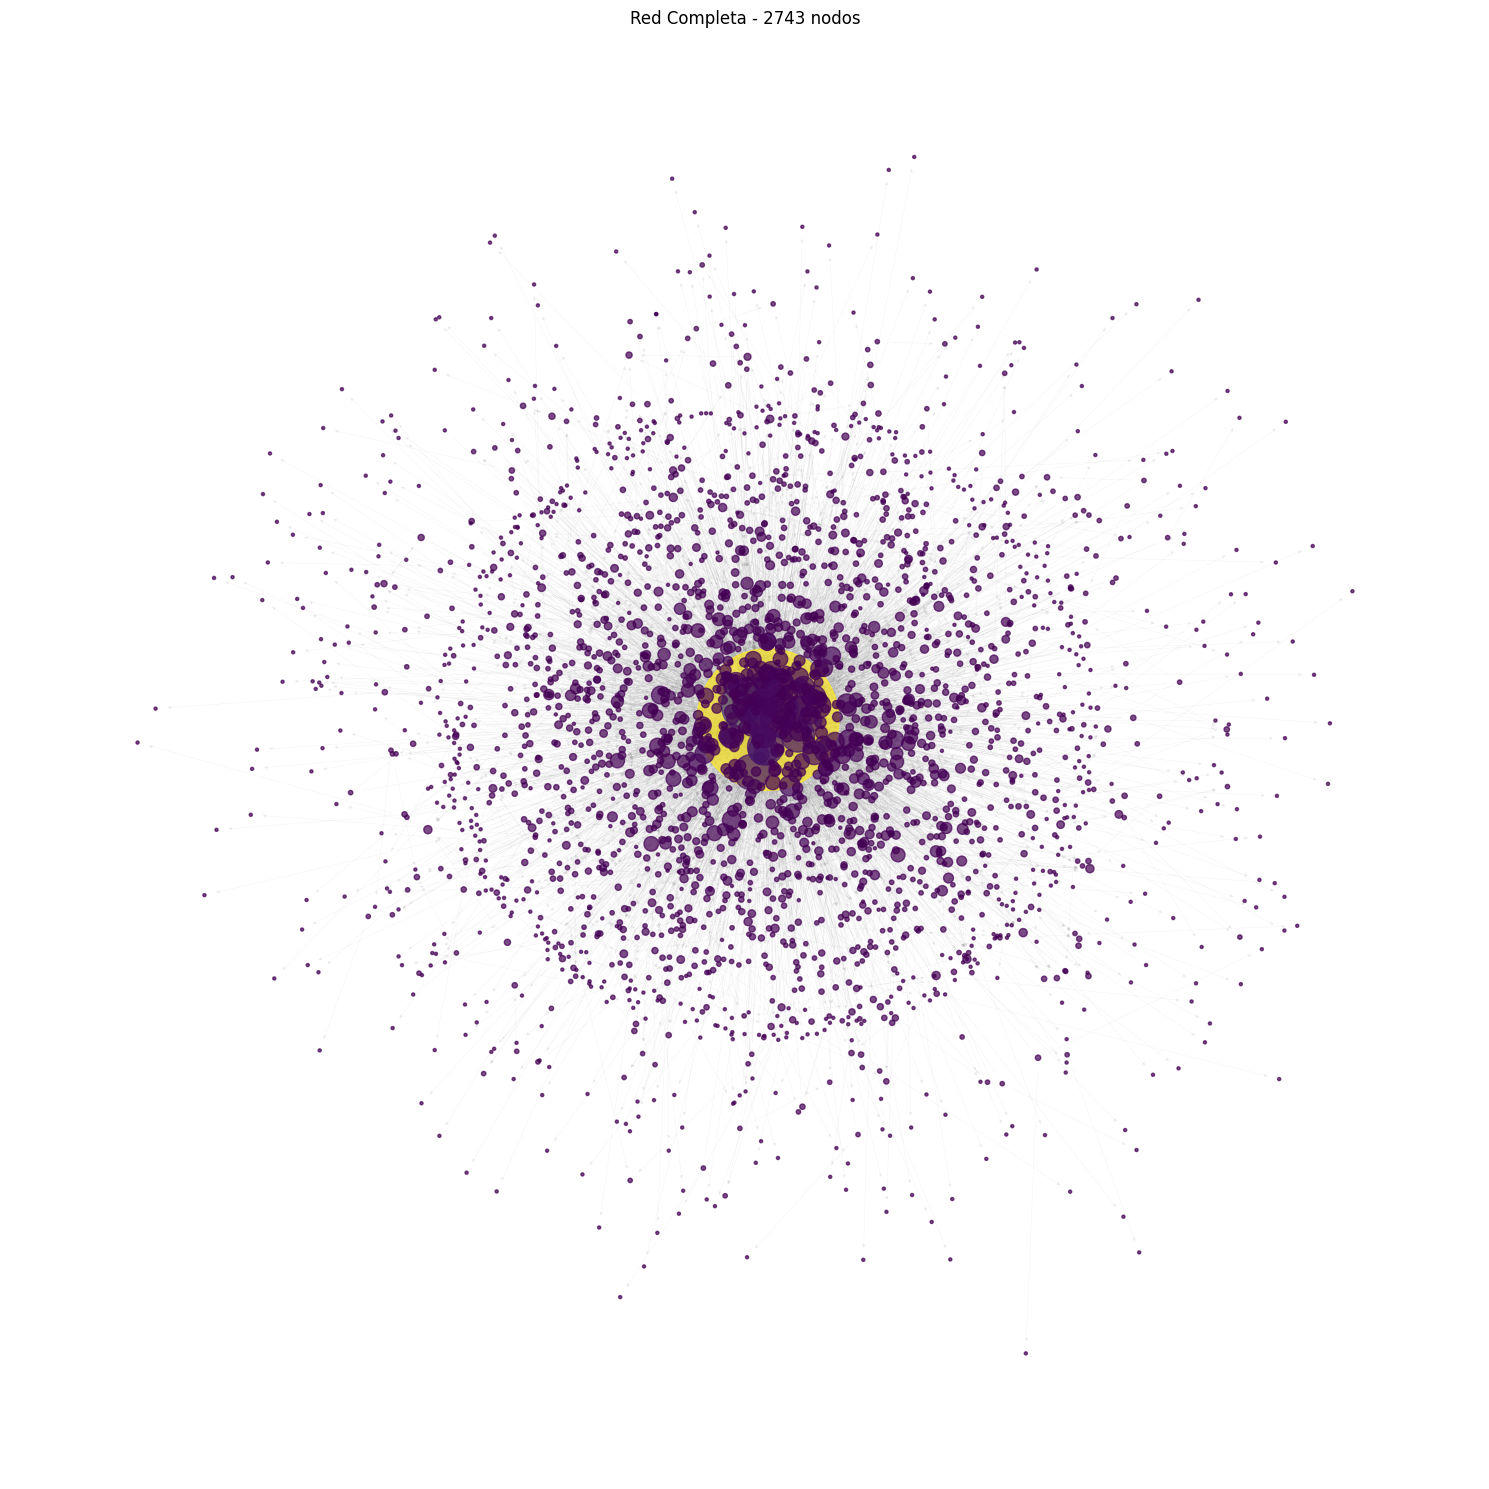

In [51]:
plt.figure(figsize=(15, 15))

# Layout para toda la red
pos = nx.spring_layout(G, k=0.5, iterations=50)  # k controla separación

# Tamaños y colores basados en métricas
node_sizes = [total_degrees[n] * 5 for n in G.nodes()]  # Tamaño por grado total
in_deg_values = [in_degrees[n] for n in G.nodes()]

# Dibujar la red completa
nx.draw_networkx_nodes(G, pos, 
                      node_size=node_sizes,
                      node_color=in_deg_values, 
                      cmap='viridis', 
                      alpha=0.7)

nx.draw_networkx_edges(G, pos, 
                      alpha=0.1,  # Transparencia baja para ver mejor
                      edge_color='gray',
                      arrows=True, 
                      arrowsize=5,
                      width=0.3)

plt.title(f'Red Completa - {G.number_of_nodes()} nodos')
plt.axis('off')
plt.tight_layout()
plt.show()

# Analisis de comunidades

In [55]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import community as community_louvain  # pip install python-louvain
from matplotlib.colors import ListedColormap

print("6.1 ALGORITMOS DE DETECCIÓN DE COMUNIDADES\n")

# El algoritmo más usado es LOUVAIN aka modularity optimization
# Para grafos dirigidos, convertimos a no dirigido manteniendo pesos
G_undirected = G.to_undirected()

# Agregar pesos si las aristas no los tienen
for edge in G_undirected.edges():
    if 'weight' not in G_undirected[edge[0]][edge[1]]:
        G_undirected[edge[0]][edge[1]]['weight'] = 1

print("Algoritmo seleccionado: LOUVAIN")

# Aplicar algoritmo de Louvain
partition = community_louvain.best_partition(G_undirected, weight='weight')

# Calcular modularidad
modularity = community_louvain.modularity(partition, G_undirected, weight='weight')

print(f"Comunidades detectadas: {len(set(partition.values()))}")
print(f"Modularidad: {modularity:.4f}")

# Análisis de tamaños de comunidades
community_sizes = Counter(partition.values())
communities_sorted = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)

print("Distribución de tamaños de comunidades:")
for i, (comm_id, size) in enumerate(communities_sorted[:10]):
    percentage = (size / len(partition)) * 100
    print(f"Comunidad {comm_id}: {size} usuarios ({percentage:.1f}%)")


6.1 ALGORITMOS DE DETECCIÓN DE COMUNIDADES

Algoritmo seleccionado: LOUVAIN
Comunidades detectadas: 45
Modularidad: 0.3816
Distribución de tamaños de comunidades:
Comunidad 0: 908 usuarios (33.1%)
Comunidad 3: 229 usuarios (8.3%)
Comunidad 10: 217 usuarios (7.9%)
Comunidad 8: 210 usuarios (7.7%)
Comunidad 1: 166 usuarios (6.1%)
Comunidad 7: 147 usuarios (5.4%)
Comunidad 11: 117 usuarios (4.3%)
Comunidad 13: 96 usuarios (3.5%)
Comunidad 12: 95 usuarios (3.5%)
Comunidad 5: 84 usuarios (3.1%)


In [ ]:
# el analisis de las comunidades ta pendiente